In [ ]:
#Packages needed
#!pip install tensorflow==2.1.0
#!pip install --upgrade pip
#!pip install numpy libtiff
#!pip install tensorflow_addons==0.9.1
#!pip install opencv-python
#!pip install pydot
#!pip install pydotplus


In [ ]:
#Imports
import tensorflow as tf
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import random
plt.rcParams.update({'figure.max_open_warning': 0})
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from tensorflow.keras import layers, Model, utils, losses, optimizers
tf.keras.utils.Sequence
from libtiff import TIFF
from scipy.signal import convolve2d
from PIL import Image
import pandas as pd
import tensorflow_addons as tfa
import copy
import pydot
from pydotplus import graphviz
tf.debugging.set_log_device_placement(True)

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# ELASTIC DEFORMATION ALGORITHM

"""
This function is copied from https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a and it was modified to serve our purposes """

def elastic_transform(image, label, alpha = 190, sigma = 10, random_state=None, margin = 15):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """

    """Takes a list of images as input and returns a list of images as output with the same deformations 
    """
    assert len(image.shape)==2
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape
    shapev = tuple(np.subtract(shape, (margin*2, margin*2)))

    dx = gaussian_filter((random_state.rand(*shapev) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shapev) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dx = np.pad(dx, [(margin, margin), (margin, margin)], mode='constant')
    dy = np.pad(dy, [(margin, margin), (margin, margin)], mode='constant')

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    image = map_coordinates(image, indices, order=1).reshape(shape)

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    label = map_coordinates(label, indices, order=1).reshape(shape)

    return image, label

""" Our functions """
def elastic_transform_data(images, labels, alpha = 190, sigma = 10, random_state=None, margin = 15):
    transf_images = np.empty_like(images)
    transf_labels = np.empty_like(labels)
    assert len(images)==len(labels)
    for i in range(len(images)):
        transf_images[i], transf_labels[i] = elastic_transform(images[i], labels[i], alpha, sigma, random_state, margin)
    return transf_images, transf_labels

def add_noise(images, labels, sigma = 0.1):
    noisy_images = np.empty_like(images)
    for i in range(len(images)):
        noise = np.random.normal(0, sigma, images[i].shape)
        noisy_images[i] = images[i] + noise
    return noisy_images, labels

def add_borders(images, labels=None, border_size=92):
    # size of border is 92 because dim_input - dim_output / 2 = border so 572 - 388 / 2 = 92
    if labels == None:
        border_images = np.empty((images.shape[0], images.shape[1] + border_size*2, images.shape[2] + border_size*2))
        for i in range(len(images)):
            border_images[i] = cv2.copyMakeBorder(images[i], border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT)
        del images
        return border_images
    else:
        border_images = np.empty((images.shape[0], images.shape[1] + border_size*2, images.shape[2] + border_size*2))
        border_labels = np.empty((labels.shape[0], labels.shape[1] + border_size*2, labels.shape[2] + border_size*2))
        for i in range(len(images)):
            border_images[i] = cv2.copyMakeBorder(images[i], border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT)
            border_labels[i] = cv2.copyMakeBorder(labels[i], border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT)
        del images, labels
        return border_images, border_labels

def split_data(images, labels):
    a = np.concatenate((images[np.newaxis], labels[np.newaxis]))
    #print(f'a size {a.shape}, image_size {images.shape}')
    s = np.concatenate((a[:, :, 0:572, 0:572],
                        a[:, :, 0:572, 124:],
                        a[:, :, 124:, 0:572],
                        a[:, :, 124:, 124:]), axis=1)  
    #print(f's size {s.shape}')
    del images, labels
    return s[0], s[1]

def crop_labels(labels):
    cropped_lab = []
    for label in labels:
        cropped_lab.append(label[92:480, 92:480])
    cropped_lab = np.array(cropped_lab)
    return cropped_lab


def crop_single_label(label):
    cropped_lab = np.array(label[92:480, 92:480])
    return cropped_lab

In [ ]:
train_data = TIFF.open('/home/jovyan/work/data/train-volume.tif') # open tiff file in read mode
labels_data = TIFF.open('/home/jovyan/work/data/train-labels.tif')

train_augment = []
labels_augment = []

# read all images in a TIFF file:
train_iter = train_data.iter_images()
labels_iter = labels_data.iter_images()
string = "training"
for data in [train_iter, labels_iter]:
    images_list = None
    nimages = 0
    for image in data:
        # normalize
        im = np.array(image)/255                       
        image_transform = [im, Image.fromarray(im).transpose(Image.FLIP_TOP_BOTTOM)]
        # rotate images
        for angle in [np.pi/2, np.pi, (3/2)*np.pi]: 
            rotated = tfa.image.rotate(im, tf.constant(angle))
            image_rot = np.array(rotated)
            flip_im = Image.fromarray(image_rot).transpose(Image.FLIP_TOP_BOTTOM)
            image_transform.append(image_rot)
            image_transform.append(np.array(flip_im))
        image_transform = np.stack(image_transform)
        # add reflected margins
        image_transform = add_borders(image_transform)
        # add all to training sets
        if images_list is None :
            images_list = image_transform
        else:
            images_list = np.concatenate((images_list, image_transform))
        nimages += 1
    if data == train_iter:
        train_augment = images_list
    else:
        labels_augment = images_list
    print("There are " + str(nimages) + " images in the " + string + " set")
    string = "labels"

del images_list, image_transform, flip_im, im, rotated, 
del train_iter, labels_iter, train_data, labels_data

train_augment, labels_augment = split_data(train_augment, labels_augment)

print("There are " + str(train_augment.shape[0]) + " images in the augmented training set")
print("There are " + str(labels_augment.shape[0]) + " images in the augmented labels set")
print("Size of augmented training images: " + str(train_augment[2].shape) + ".")

print("Size of augmented label images: " + str(labels_augment[2].shape) + ".")

print(train_augment.shape)
print(labels_augment.shape)
# plt.figure()
# plt.imshow(train_augment[1])
# train_augment, labels_augment = add_noise(train_augment, labels_augment, sigma = 0.1)
# plt.figure()
# plt.imshow(train_augment[1])


Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cos in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sin in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice

' train_elastic, labels_elastic = elastic_transform_data(train_augment[0:4], labels_augment[0:4])\n\nfor image in train_elastic[0:4]:\n    plt.figure()\n    plt.imshow(image)\nfor image in labels_elastic[0:4]:\n    plt.figure()\n    plt.imshow(image)\n\ntrain_elastic2, labels_elastic2 = add_noise(train_elastic, labels_elastic)\n\nfor image in train_elastic2[0:4]:\n    plt.figure()\n    plt.imshow(image)\nfor image in labels_elastic2[0:4]:\n    plt.figure()\n    plt.imshow(image) \n\nplt.figure()\nplt.imshow(train_elastic2[1] - train_elastic[1])  '

In [ ]:
#Data

test_data = TIFF.open('/home/jovyan/work/data/test-volume.tif')
test_iter = test_data.iter_images()
test_images = []
for t_data in test_iter:
    test_im = t_data/255
    test_images.append(test_im)

print(len(test_images))

# for test_image in test_images:
#     plt.imshow(test_image)
#     plt.show()


30


In [ ]:
print(labels_augment.shape)
print(train_augment.shape)

(960, 572, 572)
(960, 572, 572)


In [ ]:
dropout = True
batchnorm = True
run = 4

In [ ]:
#U-NET architecture with CNNs tensorflow keras library
INPUT_SHAPE = (572, 572, 1)
feature_maps = 64
#input - Use Input not InputLayer from Keras 
input_layer = layers.Input((INPUT_SHAPE))
#Downsampling - By maxpooling
conv_net1 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(input_layer) #valid means no padding
if batchnorm : conv_net1 = layers.BatchNormalization()(conv_net1)
conv_net1 = layers.Conv2D(feature_maps, (3,3), activation = 'relu', padding = 'valid')(conv_net1)
if batchnorm : conv_net1 = layers.BatchNormalization()(conv_net1)
max_pool1 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'valid')(conv_net1)
if dropout : max_pool1 = layers.Dropout(0.25)(max_pool1)

feature_maps *= 2
conv_net2 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(max_pool1)
if batchnorm : conv_net2 = layers.BatchNormalization()(conv_net2)
conv_net2 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(conv_net2)
if batchnorm : conv_net2 = layers.BatchNormalization()(conv_net2)
max_pool2 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'valid')(conv_net2)
if dropout : max_pool2 = layers.Dropout(0.5)(max_pool2)

feature_maps *= 2
conv_net3 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(max_pool2)
if batchnorm : conv_net3 = layers.BatchNormalization()(conv_net3)
conv_net3 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(conv_net3)
if batchnorm : conv_net3 = layers.BatchNormalization()(conv_net3)
max_pool3 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'valid')(conv_net3)
if dropout : max_pool3 = layers.Dropout(0.5)(max_pool3)

feature_maps *= 2
conv_net4 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(max_pool3)
if batchnorm : conv_net4 = layers.BatchNormalization()(conv_net4)
conv_net4 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(conv_net4)
if batchnorm : conv_net4 = layers.BatchNormalization()(conv_net4)
max_pool4 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'valid')(conv_net4)
if dropout : max_pool4 = layers.Dropout(0.5)(max_pool4)

#Bottom
feature_maps *= 2
conv_net_bn = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(max_pool4)
if batchnorm : conv_net_bn = layers.BatchNormalization()(conv_net_bn)
conv_net_bn = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'valid')(conv_net_bn)
if batchnorm : conv_net_bn = layers.BatchNormalization()(conv_net_bn)

#Upsampling - By Transposed Convolution
up_sample1 = layers.Conv2DTranspose(feature_maps, (2, 2), strides = 2, padding = 'valid')(conv_net_bn)

#Concatinating layers for crop and copy
conv_crop_1 = layers.Cropping2D(cropping = (4, 4))(conv_net4)
conv_concat_1 = layers.concatenate([conv_crop_1, up_sample1])
if dropout : conv_concat_1 = layers.Dropout(0.5)(conv_concat_1)

feature_maps /= 2
conv_net5 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'valid')(conv_concat_1)
if batchnorm : conv_net5 = layers.BatchNormalization()(conv_net5)
conv_net5 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'valid')(conv_net5)
if batchnorm : conv_net5 = layers.BatchNormalization()(conv_net5)

up_sample2 = layers.Conv2DTranspose(int(feature_maps), (2, 2), strides = 2, padding = 'valid')(conv_net5)

conv_crop_2 = layers.Cropping2D(cropping = (16, 16))(conv_net3)
conv_concat_2 = layers.concatenate([conv_crop_2, up_sample2])
if dropout : conv_concat_2 = layers.Dropout(0.5)(conv_concat_2)

feature_maps /= 2
conv_net6 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'valid')(conv_concat_2)
if batchnorm : conv_net6 = layers.BatchNormalization()(conv_net6)
conv_net6 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'valid')(conv_net6)
if batchnorm : conv_net6 = layers.BatchNormalization()(conv_net6)

up_sample3 = layers.Conv2DTranspose(int(feature_maps), (2, 2), strides = 2, padding = 'valid')(conv_net6)

conv_crop_3 = layers.Cropping2D(cropping = (40, 40))(conv_net2)
conv_concat_3 = layers.concatenate([conv_crop_3, up_sample3])
if dropout : conv_concat_3 = layers.Dropout(0.5)(conv_concat_3)

feature_maps /= 2
conv_net7 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'valid')(conv_concat_3)
if batchnorm : conv_net7 = layers.BatchNormalization()(conv_net7)
conv_net7 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'valid')(conv_net7)
if batchnorm : conv_net7 = layers.BatchNormalization()(conv_net7)

up_sample4 = layers.Conv2DTranspose(int(feature_maps), (2, 2), strides = 2, padding = 'valid')(conv_net7)

conv_crop_4 = layers.Cropping2D(cropping = (88, 88))(conv_net1) #cropping size calculated from the architecure by subtracting final image size and initial image size
conv_concat_4 = layers.concatenate([conv_crop_4, up_sample4])
if dropout : conv_concat_4 = layers.Dropout(0.5)(conv_concat_4)

feature_maps /= 2
conv_net8 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'valid')(conv_concat_4)
if batchnorm : conv_net8 = layers.BatchNormalization()(conv_net8)
conv_net8 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'valid')(conv_net8)
if batchnorm : conv_net8 = layers.BatchNormalization()(conv_net8)
#output
conv_net_out = layers.Conv2D(1, (1, 1), padding = 'valid', activation = 'sigmoid')(conv_net8) #Should there be activation in this? B..Resolved B

unet_model = Model(input_layer, conv_net_out)
unet_model.summary()

#tf.keras.utils.plot_model(unet_model, show_shapes=True, to_file="unet_model.png")


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, train_augment, labels_augment):
        self.train = train_augment
        self.labels = labels_augment
        self.flag = False
    
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.flag = True

    def __len__(self):
        return math.ceil(len(self.train))

    def __getitem__(self, idx):
        t = copy.deepcopy(self.train[idx:idx+1])
        l = copy.deepcopy(self.labels[idx:idx+1])
        if self.flag:                                    #### NO AUGM : COMMENT THIS
            x, y = elastic_transform_data(t, l)          ####
            #x, y = add_noise(x, y)                       ####
            y = crop_labels(y)                           ####  (REMOVE FOR FUSION NET)
            x = x                                        ####
        else:                                            ####
            y = crop_labels(l)                           ####  (REMOVE FOR FUSION NET)
            x = t
        return np.expand_dims(x, axis=-1), np.expand_dims(y, axis=-1)


print(train_augment.shape)
print(labels_augment.shape)

(960, 572, 572)
(960, 572, 572)


In [ ]:

### Implementation with augmentation 
train_datagen = DataGenerator(train_augment, labels_augment)

print('Training!')
unet_model.compile(optimizer = 'Adam',                        
                    loss = 'binary_crossentropy',
                    metrics=['accuracy'])

unet_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='accuracy',min_delta=1e-2,patience=2,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='/home/jovyan/work/checkpoints/unet_run_4.hdf5',
                                        save_best_only=True, monitor='accuracy',
                                        verbose=1)
]


print('Fit model on training data: ')
with tf.device('/GPU:0'):
    unet_model_history = unet_model.fit(train_datagen, epochs = 100, callbacks = unet_callbacks)
                            

print('\nhistory dict:', unet_model_history.history)


Training!
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Fit model on training data: 
  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 960 steps
Epoch 1/100
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/

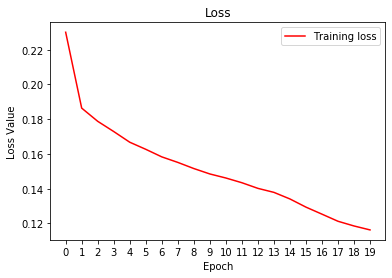

In [ ]:
#Training and Validation loss plot
training_loss = unet_model_history.history['loss']
#val_loss = unet_model_history.history['val_loss']

epochs = 100

plt.figure()
plt.plot(training_loss, 'r', label='Training loss')
#plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.ylim([0, 1])
plt.xticks(np.arange(0, 20, 1))
plt.legend()
plt.show()
#plt.savefig('/home/jovyan/work/plots/loss_' + str(run))



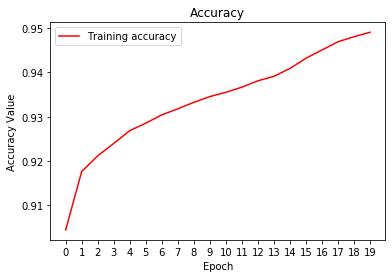

In [ ]:
#Training and Validation accuracy plot

training_acc = unet_model_history.history['accuracy']
#val_acc = unet_model_history.history['val_accuracy']

epochs = 100

plt.figure()
plt.plot(training_acc, 'r', label='Training accuracy')
#plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
#plt.ylim([0, 1])
plt.xticks(np.arange(0, 20, 1))
plt.legend()
plt.show()
#plt.savefig('/home/jovyan/work/plots/accuracy_' + str(run))


In [ ]:
unet_model.load_weights('/home/jovyan/work/checkpoints/unet_run_4.hdf5')

print(len(test_images))
test_images_predcit = []
for im_test in test_images:
    test_images_predcit.append(np.array(im_test)) 

test_images_array = np.array(test_images_predcit)


print(test_images_array.shape)

test_images_padded = add_borders(test_images_array)
test_data_augumented, _ = split_data(test_images_padded, test_images_padded)

print(test_data_augumented.shape)

test_data_augumented = np.expand_dims(test_data_augumented, axis=3)

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
prediction = unet_model.predict(test_data_augumented, batch_size=1)
#print(prediction)

30
(30, 512, 512)
(120, 572, 572)

# Evaluate on test data
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in devi

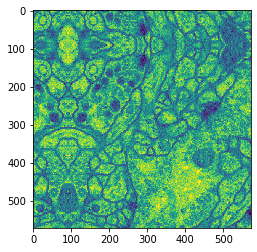

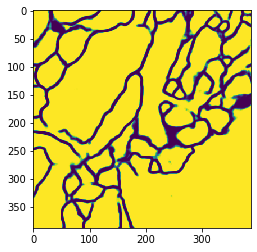

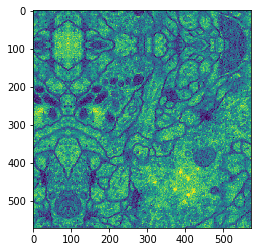

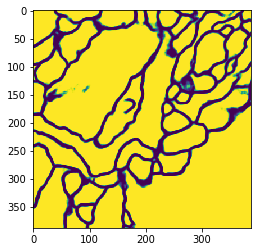

In [ ]:
for index in range(2):
    test_image = test_data_augumented[index][:,:,0]
    plt.imshow(test_image)
    plt.show()
    # plt.savefig('/home/jovyan/work/results/test_img_run' + str(run) + '_' + str(index) + '.png')

    predicted_image = prediction[index][:,:,0]
    plt.imshow(predicted_image)
    plt.show()

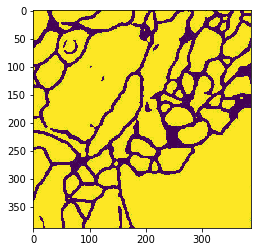

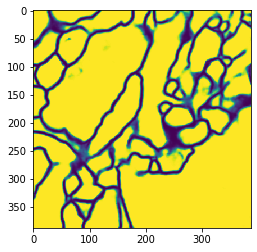

0.8834227866935912


In [ ]:
#prediction = unet_model.predict(test_data_augumented, batch_size=1)

test_data = TIFF.open('/home/jovyan/work/testgit/0.tif')
testim = test_data.read_image()
testarr = np.array(testim)/255

img = Image.open('/home/jovyan/work/testgit/0.jpg')

truth_lab = np.array(img)/255
truth_lab = truth_lab[:388, :388]

plt.imshow(truth_lab)
plt.show()

predicted_image = prediction[0][:,:,0]

plt.imshow(predicted_image)
plt.show()
#IOU score
intersection = np.logical_and(truth_lab, predicted_image)
union = np.logical_or(truth_lab, predicted_image)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

In [ ]:
# you have to load the model 4 to get results for model 4..did you load it?
#i think this is the last model ie model 5

tif = TIFF.open('/home/jovyan/work/data/predictions.tif', mode='w')
# to write a image to tiff file

for index in range(2):
    test_image = test_images_padded[index][:,:,0]
    test_image = crop_image(test_image, 512)
    #plt.imshow(test_image)
    #plt.show()
    # plt.savefig('/home/jovyan/work/results/test_img_run' + str(run) + '_' + str(index) + '.png')

    predicted_image = prediction[index][:,:,0]
    predicted_image = crop_image(predicted_image, 512)
    tif.write_image(predicted_image)
    #plt.imshow(predicted_image)
    #plt.show()
    # plt.savefig('/home/jovyan/work/results/predict_img_run' + str(run) + '_' + str(index) + '.png')


alttiff = TIFF.open('/home/jovyan/work/data/predictions.tif')
count = 0
for image in alttiff.iter_images():
    count = count + 1

print("Shape of images in written tiff file: " + str(image.shape))
print("Number of images in written tiff file: " + str(count))